# Lecture 3: Time Series Graphics

*DASCI 270 - Time Series Analysis*

*Prepared by Sebastian C. Ibañez, PhD*

*Based on [FPPY Chapter 2](https://otexts.com/fpppy/nbs/02-graphics.html)*

`Forecasting is the ultimate tool for a pragmatist.`

In [1]:
%%capture
!pip install statsforecast
!pip install utilsforecast

!wget 'https://raw.githubusercontent.com/scibanez/msds2025ptb-tsa/refs/heads/main/data/olympic_running_unparsed.csv' -P ./data/
!wget 'https://raw.githubusercontent.com/scibanez/msds2025ptb-tsa/refs/heads/main/data/PBS_unparsed.csv' -P ./data/
!wget 'https://raw.githubusercontent.com/scibanez/msds2025ptb-tsa/refs/heads/main/data/prison_population.csv' -P ./data/
!wget 'https://raw.githubusercontent.com/scibanez/msds2025ptb-tsa/refs/heads/main/data/ansett.csv' -P ./data/
!wget 'https://raw.githubusercontent.com/scibanez/msds2025ptb-tsa/refs/heads/main/data/vic_elec.csv' -P ./data/
!wget 'https://raw.githubusercontent.com/scibanez/msds2025ptb-tsa/refs/heads/main/data/tourism.csv' -P ./data/
!wget 'https://raw.githubusercontent.com/scibanez/msds2025ptb-tsa/refs/heads/main/data/aus_production.csv' -P ./data/
!wget 'https://raw.githubusercontent.com/scibanez/msds2025ptb-tsa/refs/heads/main/data/tute1.csv' -P ./data/

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utilsforecast.plotting import plot_series as plot_series_utils
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

plt.style.use("ggplot")
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#000000", "#000000"])

plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})

pd.set_option("max_colwidth", 100)

## `DataFrame` objects

### Creating date and period range objects

Sometimes, it might be useful to create a column of date or period range objects from scratch.

Check the [`date_range`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html) and [`period_range`](https://pandas.pydata.org/docs/reference/api/pandas.period_range.html) API for more details.

In [3]:
pd.DataFrame({'Date': pd.date_range(start='2025-01-01', periods=10, freq='h')})

,Date
0,2025-01-01 00:00:00
1,2025-01-01 01:00:00
2,2025-01-01 02:00:00
3,2025-01-01 03:00:00
4,2025-01-01 04:00:00
5,2025-01-01 05:00:00
6,2025-01-01 06:00:00
7,2025-01-01 07:00:00
8,2025-01-01 08:00:00
9,2025-01-01 09:00:00


In [4]:
pd.DataFrame({'Date': pd.date_range(start='2021-01-01', periods=5, freq='D')})

,Date
0,2021-01-01
1,2021-01-02
2,2021-01-03
3,2021-01-04
4,2021-01-05


In [5]:
pd.DataFrame({'Date': pd.period_range(start='2017Q1', end='2019Q3', freq='Q')})

,Date
0,2017Q1
1,2017Q2
2,2017Q3
3,2017Q4
4,2018Q1
5,2018Q2
6,2018Q3
7,2018Q4
8,2019Q1
9,2019Q2


### Working with time series dataframes

We can use `pandas` functions such as `assign()`, `query()`, `filter()` and `agg()` to work with DataFrame objects.

To illustrate these, we will use the PBS, containing sales data on pharmaceutical products in Australia.

In [6]:
pbs = pd.read_csv("data/PBS_unparsed.csv")
pbs["Month"] = pd.to_datetime(pbs["Month"])
pbs.head()

,Month,Concession,Type,ATC1,ATC1_desc,ATC2,ATC2_desc,Scripts,Cost
0,1991-07-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,18228,67877.0
1,1991-08-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15327,57011.0
2,1991-09-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14775,55020.0
3,1991-10-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15380,57222.0
4,1991-11-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14371,52120.0


This contains monthly data on Medicare Australia prescription data from July 1991 to June 2008. These are classified according to various concession types, and Anatomical Therapeutic Chemical (ATC) indexes. For this example, we are interested in the `Cost` time series (total cost of scripts in Australian dollars).

We can use the `query()` function to extract the A10 scripts:

In [7]:
a10 = pbs.query('ATC2 == "A10"')
a10 = a10.filter(["Month", "Concession", "Type", "Cost"])
a10

,Month,Concession,Type,Cost
1524,1991-07-01,Concessional,Co-payments,2092878.0
1525,1991-08-01,Concessional,Co-payments,1795733.0
1526,1991-09-01,Concessional,Co-payments,1777231.0
1527,1991-10-01,Concessional,Co-payments,1848507.0
1528,1991-11-01,Concessional,Co-payments,1686458.0
...,...,...,...,...
52339,2008-02-01,General,Safety net,530709.0
52340,2008-03-01,General,Safety net,51773.0
52341,2008-04-01,General,Safety net,36289.0
52342,2008-05-01,General,Safety net,101233.0


This allows rows of the dataframe to be selected. Next we can simplify the resulting object by selecting the columns we will need in subsequent analysis.

In [8]:
a10 = a10.filter(["Month", "Concession", "Type", "Cost"])
a10

,Month,Concession,Type,Cost
1524,1991-07-01,Concessional,Co-payments,2092878.0
1525,1991-08-01,Concessional,Co-payments,1795733.0
1526,1991-09-01,Concessional,Co-payments,1777231.0
1527,1991-10-01,Concessional,Co-payments,1848507.0
1528,1991-11-01,Concessional,Co-payments,1686458.0
...,...,...,...,...
52339,2008-02-01,General,Safety net,530709.0
52340,2008-03-01,General,Safety net,51773.0
52341,2008-04-01,General,Safety net,36289.0
52342,2008-05-01,General,Safety net,101233.0


The `filter()` method of Pandas allows us to select particular columns, while `query()` method allows us to keep particular rows.

Another useful method is `agg()` which allows us to combine data across keys. For example, we may wish to compute total cost per month regardless of the `Concession` or `Type` keys.

In [9]:
total_cost_df = a10.groupby("Month", as_index=False).agg({"Cost": "sum"})
total_cost_df.rename(columns={"Cost": "TotalC"}, inplace=True)
total_cost_df

,Month,TotalC
0,1991-07-01,3526591.0
1,1991-08-01,3180891.0
2,1991-09-01,3252221.0
3,1991-10-01,3611003.0
4,1991-11-01,3565869.0
...,...,...
199,2008-02-01,21654285.0
200,2008-03-01,18264945.0
201,2008-04-01,23107677.0
202,2008-05-01,22912510.0


The new column `TotalC` represents the sum of all `Cost` values for each month.

We can create new variables using the `assign()` function. Here we change the units from dollars to millions of dollars:

In [10]:
total_cost_df = total_cost_df.assign(
    Cost = round(total_cost_df["TotalC"] / 1e6, 2) # change the units from dollars to millions of dollars
)
total_cost_df

,Month,TotalC,Cost
0,1991-07-01,3526591.0,3.53
1,1991-08-01,3180891.0,3.18
2,1991-09-01,3252221.0,3.25
3,1991-10-01,3611003.0,3.61
4,1991-11-01,3565869.0,3.57
...,...,...,...
199,2008-02-01,21654285.0,21.65
200,2008-03-01,18264945.0,18.26
201,2008-04-01,23107677.0,23.11
202,2008-05-01,22912510.0,22.91


Next, we will save the resulting dataframe to a CSV file for use in examples later in this chapter. This allows us to easily reload the data without having to recompute it. If you are running this code make sure to specify the correct path to save the file in your own working directory.

In [11]:
total_cost_df.to_csv("data/total_cost_df.csv", index=False)

### The seasonal period

Seasonalities are particularly important for time series analysis. Some graphics and some models rely on the repeated seasonal period of the data. The seasonal period is the number of observations before a seasonal pattern repeats. In most cases, this will be automatically detected using the time index variable.

Some common periods for different time intervals are shown in the table below:

| | Minute | Hour | Day | Week | Year |
| :- | - | - | - | - | - |
| Quarters |  |  |  |  | 4 |
| Months |  |  |  |  | 12 |
| Weeks |  |  |  |  | 52 |
| Days |  |  |  | 7 | 365.25 |
| Hours |  |  | 24 | 168 | 8766 |
| Minutes |  | 60 | 1440 | 10080 | 525960 |
| Seconds | 60 | 3600 | 86400 | 604800 | 31557600 |

Some notes:
- For quarterly, monthly and weekly data, there is only one seasonal period — the number of observations within each year.
- There are not $52$ weeks in a year, but $365.25/7=52.18$ on average, allowing for a leap year every fourth year.
- Approximating seasonal periods to integers can be useful as many seasonal terms in models only support integer seasonal periods.
- If the data is observed more than once per week, then there is often more than one seasonal pattern in the data.
- More complicated (and unusual) seasonal patterns can be specified using the `seasonal_decompose()` function in the `statsmodels` package.

## Time plots

For time series data, the obvious graph to start with is a time plot. That is, the observations are plotted against the time of observation, with consecutive observations joined by straight lines.

The figure below shows the weekly economy passenger load on Ansett airlines between Australia's two largest cities (Melbourne and Sydney).

In [12]:
def plot_series(df, time_col, target_col, ylabel, xlabel, title):
  df = df.set_index(time_col)
  df[target_col].plot()
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

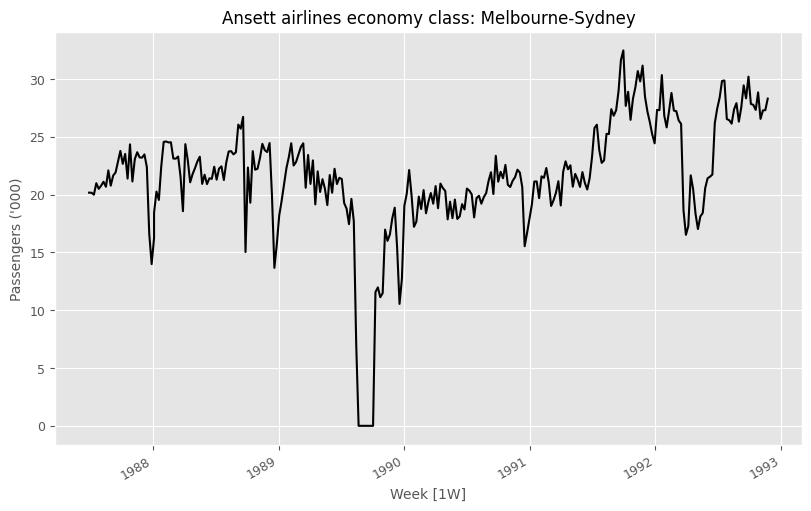

In [13]:
ansett = pd.read_csv("data/ansett.csv")
ansett["ds"] = pd.to_datetime(ansett["ds"])
melsyd_economy = ansett.query(
        'Airports == "MEL-SYD" & Class == "Economy"'
    ).copy()
melsyd_economy["y"] = melsyd_economy["y"] / 1000

plot_series(df=melsyd_economy,
            time_col="ds",
            target_col="y",
            ylabel="Passengers ('000)",
            xlabel="Week [1W]",
            title="Ansett airlines economy class: Melbourne-Sydney")

This plot reveals some interesting features.

- There was a period in 1989 when no passengers were carried — this was due to an industrial dispute.
- There was a period of reduced load in 1992. This was due to a trial in which some economy class seats were replaced by business class seats.
- A large increase in passenger load occurred in the second half of 1991.
- There are some large dips in load around the start of each year. These are due to holiday effects.
- There is a long-term fluctuation in the level of the series which increases during 1987, decreases in 1989, and increases again through 1990 and 1991.

Any model will need to take all these features into account in order to effectively forecast the passenger load into the future.

A simpler time series is shown in the figure below.

In this case, given that we aggregated the data before, we have just one unique time series and we don't have a `unique_id` column so we need to create one.

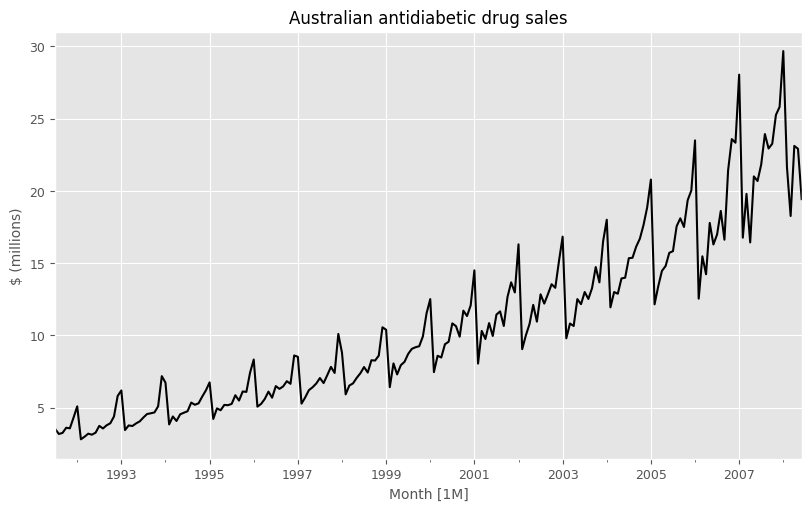

In [14]:
plot_series(total_cost_df,
            time_col="Month",
            target_col="Cost",
            xlabel="Month [1M]",
            ylabel="$ (millions)",
            title="Australian antidiabetic drug sales")

Some notes:
- Here, there is a clear and increasing trend.
- There is also a strong seasonal pattern that increases in size as the level of the series increases.
- The sudden drop at the start of each year is caused by a government subsidisation scheme that makes it cost-effective for patients to stockpile drugs at the end of the calendar year.

Any forecasts of this series would need to capture the seasonal pattern, and the fact that the trend is changing slowly.

## Time series patterns

Let's precisely define some of the terms that we've been using so far to describe time series plots.

#### Trend

A **trend** exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes we will refer to a trend as “changing direction,” when it might go from an increasing trend to a decreasing trend.

#### Seasonal

A **seasonal** pattern occurs when a time series is affected by seasonal factors such as the time of the year, the day of the week or the hour of the day. Seasonality is always of a fixed and known period. Note that one series can have more than one seasonal pattern.

#### Cyclic

A **cycle** occurs when the data exhibit rises and falls that are not of a fixed frequency. For economic or business time series, fluctuations are usually due to economic conditions, and are often related to the "business cycle".

### Examples

<img src="https://otexts.com/fpppy/nbs/02-graphics_files/figure-html/fig-fourexamples-output-1.png" width="100%">

1. The monthly housing sales (top left) show strong seasonality within each year, as well as some strong cyclic behaviour with a period of about 6–10 years. There is no apparent trend in the data over this period.
2. The US treasury bill contracts (top right) show results from the Chicago market for 100 consecutive trading days in 1981. Here there is no seasonality, but an obvious downward trend. Possibly, if we had a much longer series, we would see that this downward trend is actually part of a long cycle, but when viewed over only 100 days it appears to be a trend.
3. The Australian quarterly electricity production (bottom left) shows a strong increasing trend, with strong seasonality. There is no evidence of any cyclic behaviour here.
4. The daily change in the Google closing stock price (bottom right) has no trend, seasonality or cyclic behaviour. There are random fluctuations which do not appear to be very predictable, and no strong patterns that would help with developing a forecasting model.



## Seasonal plots

A seasonal plot is similar to a time plot except that the data are plotted against the individual “seasons” in which the data were observed.

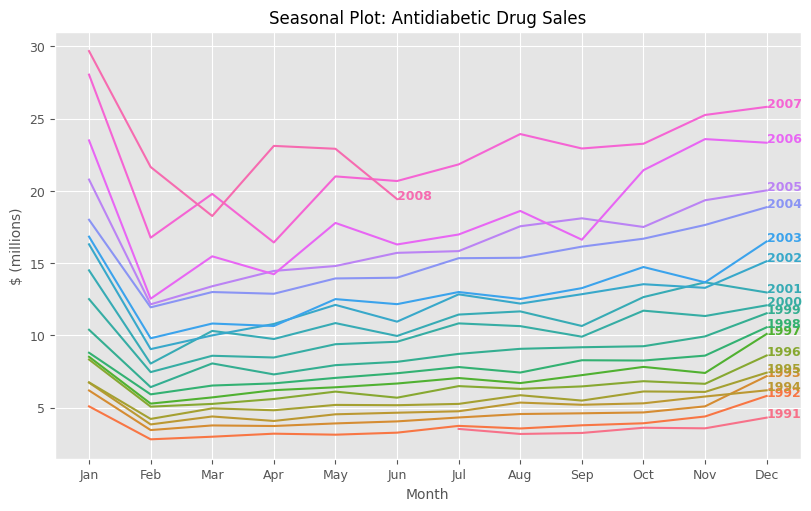

In [15]:
total_cost_df["Month_name"] = total_cost_df["Month"].dt.strftime("%b")
total_cost_df["Year"] = total_cost_df["Month"].dt.year
total_cost_df["Month_num"] = total_cost_df["Month"].dt.month

unique_years = total_cost_df["Year"].unique()
year_palette = sns.color_palette("husl", n_colors=len(unique_years))

fig, ax = plt.subplots()
sns.lineplot(
    data=total_cost_df,
    x="Month_num",
    y="Cost",
    hue="Year",
    palette=year_palette,
    legend=False,
    ax=ax,
)
ax.set_title("Seasonal Plot: Antidiabetic Drug Sales")
ax.set_xlabel("Month")
ax.set_ylabel("$ (millions)")
ax.set_xticks(
    ticks=range(1, 13),
    labels=[
        "Jan", "Feb", "Mar", "Apr", "May", "Jun",
        "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
    ],
)

min_year = unique_years.min()
for year, subset in total_cost_df.groupby("Year"):
    ax.text(
        subset["Month_num"].iloc[-1],
        subset["Cost"].iloc[-1],
        str(year),
        fontsize=9,
        weight="bold",
        color=year_palette[year - min_year],
    )

fig.show()

This is the same data shown earlier, but now the data from each season (year) is overlapped. A seasonal plot shows the underlying seasonal pattern more clearly and helps identify years when the pattern changes.

Some notes:
- There is a large jump in sales in January each year. These are probably sales in late December as customers stockpile before the end of the calendar year, but the sales are not registered with the government until a week or two later.
- The graph also shows an unusually small number of sales in March 2008 (most other years show an increase between February and March).
- The small number of sales in June 2008 is probably due to incomplete counting of sales when the data were collected.

### Multiple seasonal periods

Where the data has more than one seasonal pattern, we can group the data according to different seasonalities and plot.

In the first plot, the three days with 25 hours are when daylight saving ended in each year and so these days contained an extra hour. There were also three days with only 23 hours each (when daylight saving started) but these are hidden beneath all the other lines on the plot.

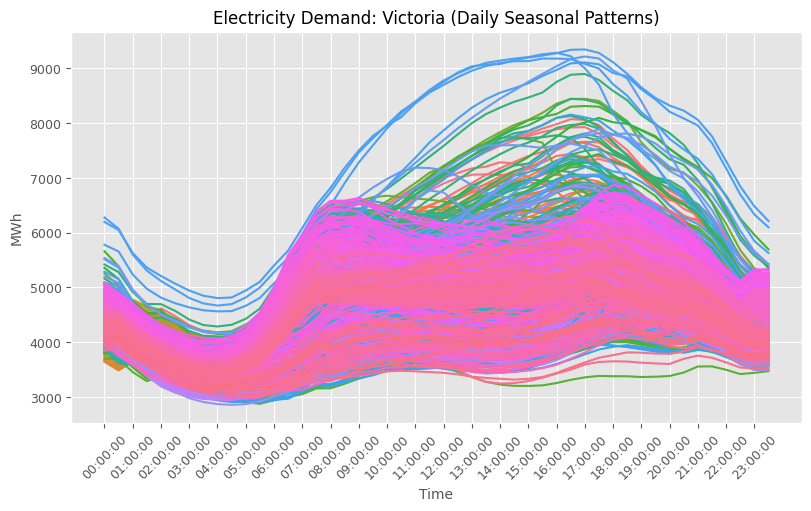

In [16]:
vic_elec_df = pd.read_csv("data/vic_elec.csv")
vic_elec_df["ds"] = pd.to_datetime(vic_elec_df["ds"])
vic_elec_demand = vic_elec_df[vic_elec_df["unique_id"] == "Demand"].copy()
vic_elec_demand["hour-minute"] = \
  vic_elec_demand["ds"].dt.strftime("%H:%M:%S")
vic_elec_demand["day"] = vic_elec_demand["ds"].dt.date

fig, ax = plt.subplots()
sns.lineplot(
    data=vic_elec_demand,
    x="hour-minute",
    y="y",
    hue="day",
    palette="husl",
    legend=False,
    ax=ax,
)
unique_ticks = vic_elec_demand["hour-minute"].unique()
ticks_to_plot = unique_ticks[::2]
ax.set_xticks(ticks=range(0, len(unique_ticks), 2), labels=ticks_to_plot,
    rotation=45)
ax.set_title("Electricity Demand: Victoria (Daily Seasonal Patterns)")
ax.set_xlabel("Time")
ax.set_ylabel("MWh")
fig.show()

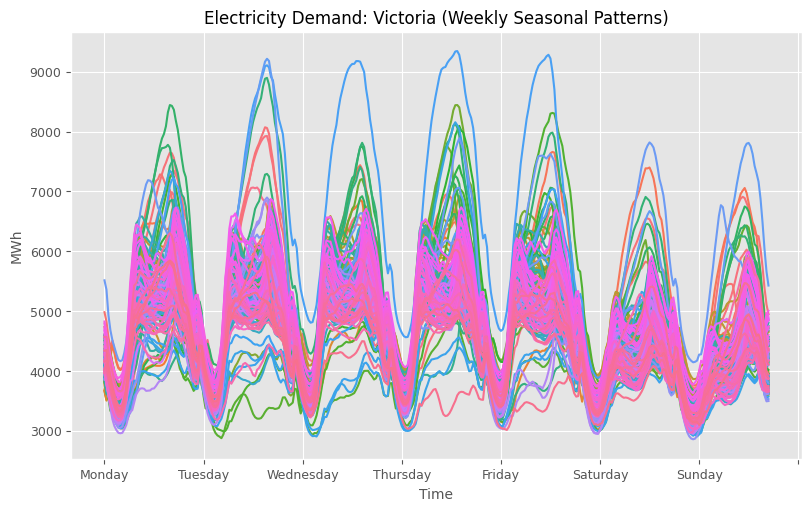

In [17]:
vic_elec_demand["day_of_week"] = vic_elec_demand["ds"].dt.day_name()
vic_elec_demand = vic_elec_demand[
    (vic_elec_demand["ds"] >= "2012-01-02") &
    (vic_elec_demand["ds"] < "2014-12-29")
].copy()

weeks = vic_elec_demand["ds"].dt.to_period("W-SUN").dt.start_time
unique_weeks = weeks.unique()
palette = sns.color_palette("husl", n_colors=len(unique_weeks))
color_map = dict(zip(unique_weeks, palette))

groups = vic_elec_demand["ds"].dt.to_period("W-SUN").dt.start_time
fig, ax = plt.subplots()
for df_week in vic_elec_demand.groupby(groups):
    week, df_w = df_week
    df_w.plot(
        y="y",
        x="day_of_week",
        ax=ax,
        color=color_map[week],
        label=str(week.date())
    )
ax.get_legend().remove()
ax.set_title("Electricity Demand: Victoria (Weekly Seasonal Patterns)")
ax.set_ylabel("MWh")
ax.set_xlabel("Time")
fig.show()

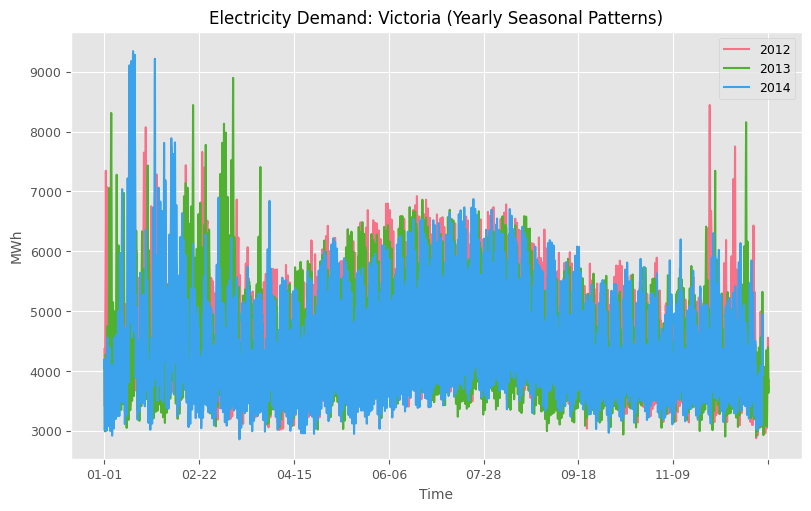

In [18]:
vic_elec_demand["day_of_year"] = vic_elec_demand["ds"].dt.strftime("%m-%d")

unique_years = vic_elec_demand["ds"].dt.year.unique()
palette = sns.color_palette("husl", n_colors=len(unique_years))
color_map = dict(zip(unique_years, palette))

fig, ax = plt.subplots()
for df_year in vic_elec_demand.groupby(vic_elec_demand["ds"].dt.year):
    year, df_y = df_year
    df_y.plot(
        y="y",
        x="day_of_year",
        ax=ax,
        label=str(year),
        color=color_map[year]
    )
ax.set_title("Electricity Demand: Victoria (Yearly Seasonal Patterns)")
ax.set_ylabel("MWh")
ax.set_xlabel("Time")
fig.show()

## Seasonal subseries plots

An alternative plot that emphasises the seasonal patterns is where the data for each season are collected together in separate mini time plots.

/tmp/ipython-input-19-3284505244.py:31: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.2)


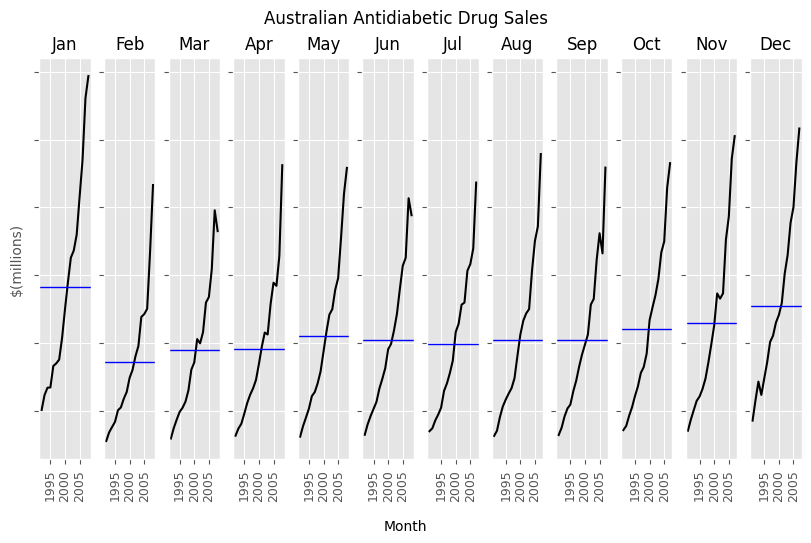

In [19]:
total_cost_df["Month"] = pd.to_datetime(total_cost_df["Month"])
total_cost_df["year"] = total_cost_df["Month"].dt.year
total_cost_df["month"] = total_cost_df["Month"].dt.strftime("%B")
total_cost_df["month"] = pd.Categorical(
  total_cost_df["month"],
  categories=[
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December",
  ],
  ordered=True,
)

fig, axes = plt.subplots(nrows=1, ncols=12, sharey=True)
for i, month in enumerate(total_cost_df["month"].cat.categories):
    month_data = total_cost_df.query("month == @month")
    mean_cost = month_data["Cost"].mean()
    axes[i].plot(month_data["year"], month_data["Cost"], color="black")
    axes[i].axhline(
        mean_cost, color="blue", linestyle="-", linewidth=1, label="Average"
    )
    axes[i].set_title(month[:3])
    axes[i].set_xlabel("")
    axes[i].tick_params(axis='x', rotation=90)
    if i == 0:
        axes[i].set_ylabel("$(millions)")
    else:
        axes[i].set_yticklabels([])

fig.suptitle("Australian Antidiabetic Drug Sales")
fig.text(0.5, -0.05, "Month", ha="center")
fig.subplots_adjust(wspace=0.2)
fig.show()

Some notes:
- The blue horizontal lines indicate the means for each month.
- This form of plot enables the underlying seasonal pattern to be seen clearly, and also shows the changes in seasonality over time. It is especially useful in identifying changes within particular seasons.
- In this example, the plot is not particularly revealing; but in some cases, this is the most useful way of viewing seasonal changes over time.

### Example: Australian holiday tourism

Australian quarterly vacation data provides an interesting example of how these plots can reveal information. First we need to extract the relevant data from the `tourism` dataframe. All the usual `pandas` wrangling functions apply. To get the total visitor nights spent on Holiday by State for each quarter (i.e., ignoring Regions) we can use the following code.

In [20]:
tourism = pd.read_csv("data/tourism.csv")
tourism["ds"] = pd.to_datetime(tourism["ds"])
tourism["Quarter"] = tourism["ds"].dt.to_period("Q").astype(str)
tourism_sub = tourism.query('Purpose == "Holiday"')
trips = tourism_sub.groupby(["State", "ds"], as_index=False)["y"].sum().round(2)
trips.head(10)

,State,ds,y
0,ACT,1998-01-01,196.22
1,ACT,1998-04-01,126.77
2,ACT,1998-07-01,110.68
3,ACT,1998-10-01,170.47
4,ACT,1999-01-01,107.78
5,ACT,1999-04-01,124.64
6,ACT,1999-07-01,177.95
7,ACT,1999-10-01,217.66
8,ACT,2000-01-01,158.41
9,ACT,2000-04-01,154.81


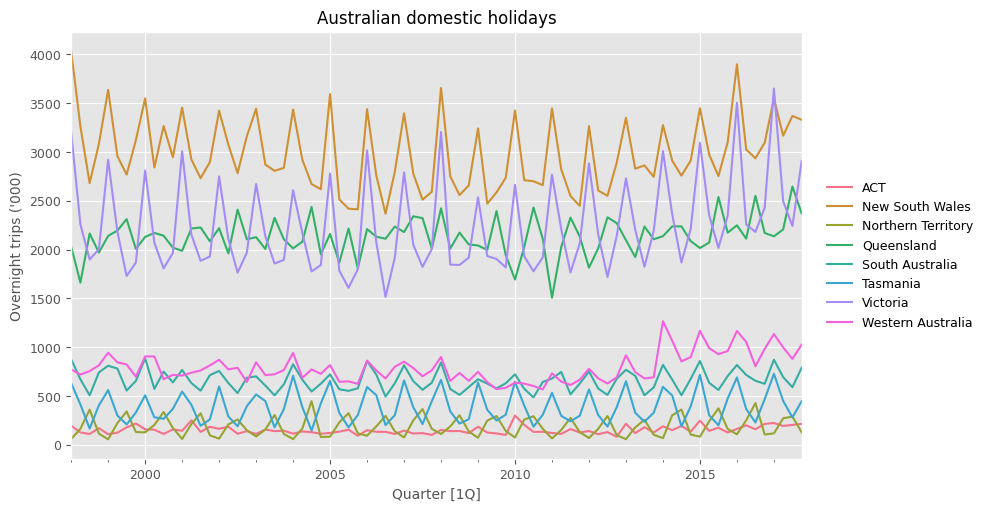

In [21]:
states = trips["State"].unique()
colors = sns.color_palette("husl", len(states))
fig, ax = plt.subplots()
for state, color in zip(states, colors):
    state_df = trips.query("State == @state")
    state_df.plot(y="y", x="ds", ax=ax, label=state, color=color)
ax.set_title("Australian domestic holidays")
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(
    handles, labels, loc="center left", bbox_to_anchor=(1.02, .5),
    frameon=False, borderaxespad=0,
)

ax.set_ylabel("Overnight trips ('000)")
ax.set_xlabel("Quarter [1Q]")
fig.show()

To see the timing of the seasonal peaks in each state, we can use a season plot. The figure below makes it clear that the southern states of Australia (Tasmania, Victoria and South Australia) have strongest tourism in Q1 (their summer), while the northern states (Queensland and the Northern Territory) have the strongest tourism in Q3 (their dry season).

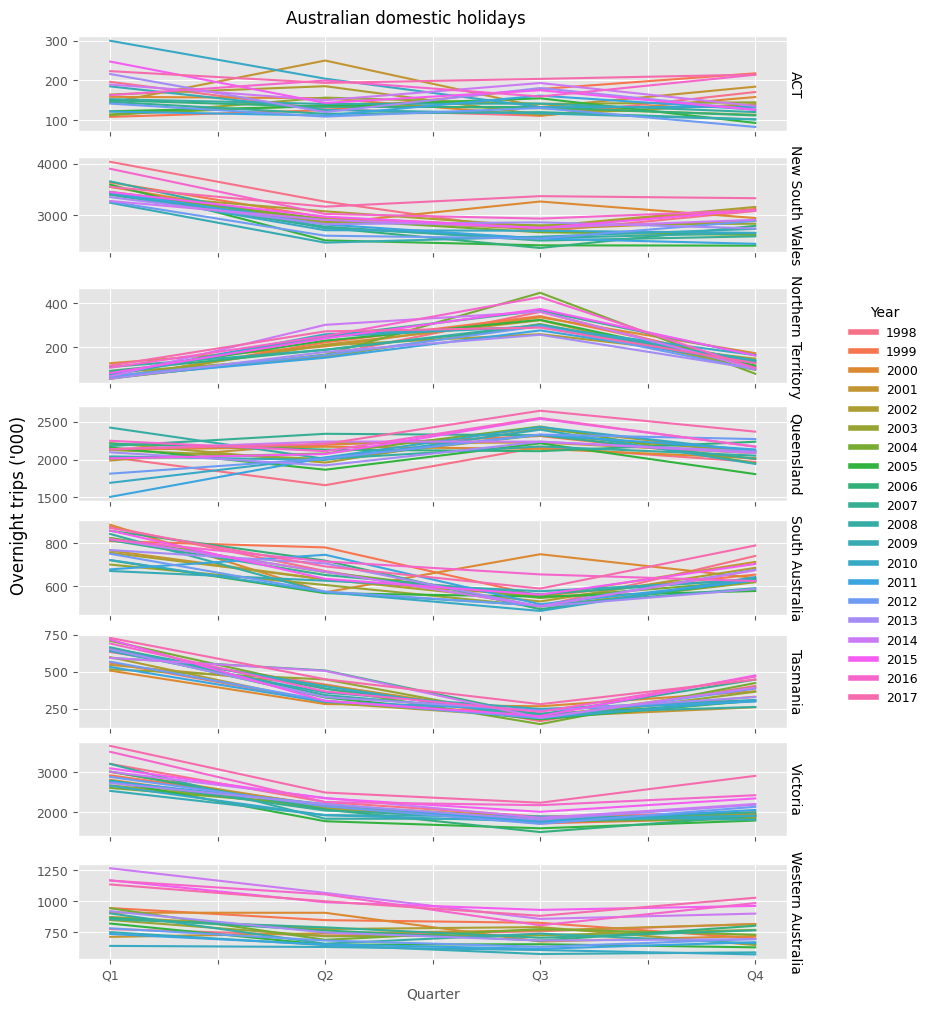

In [22]:
trips["Quarter"] = "Q" + trips["ds"].dt.quarter.astype(str)
trips["Year"] = trips["ds"].dt.year
years = sorted(trips["Year"].unique())
palette = sns.color_palette("husl", len(years))
year_to_color = dict(zip(years, palette))

n_states = trips["State"].nunique()

fig, axs = plt.subplots(n_states, 1, sharex=True, figsize=(8, 10))
for ax, (state, df_state) in zip(axs, trips.groupby("State")):
    pivot_data = df_state.pivot(index="Quarter", columns="Year", values="y")
    pivot_data.plot(ax=ax, color=[year_to_color[year] for year in pivot_data.columns])
    ax.get_legend().remove()
    ax.text(1.02, 0.5, state, va="center", ha="right", rotation=270,
        fontsize=10, transform=ax.transAxes)

handles = [plt.Line2D([0], [0], color=year_to_color[year], lw=4) for year in years]
labels = [str(year) for year in years]
fig.legend(handles, labels, title="Year", loc="center left", bbox_to_anchor=(1.05, 0.5), frameon=False, borderaxespad=0)

fig.supylabel("Overnight trips ('000)")
fig.suptitle("Australian domestic holidays")
fig.show()

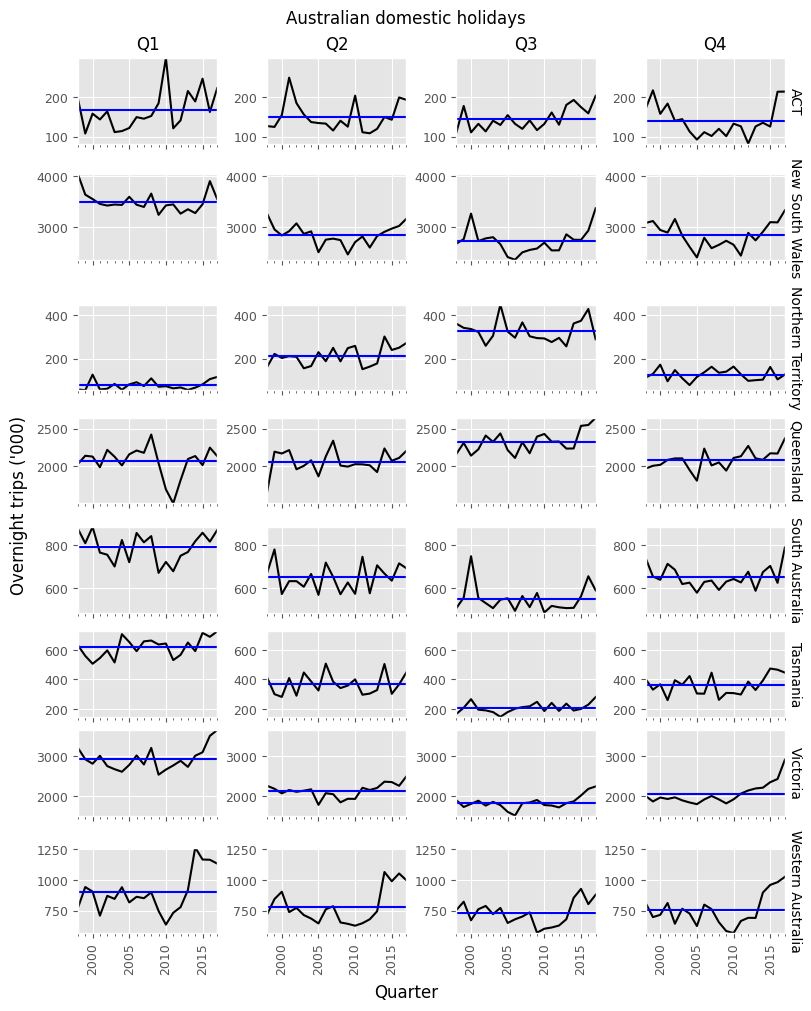

In [23]:
fig, axs = plt.subplots(n_states, 4, sharex=True, figsize=(8, 10))
axs = axs.flatten()
quarters = sorted(trips["Quarter"].unique())
states = sorted(trips["State"].unique())
for idx, (state_i, df_state) in enumerate(trips.groupby("State")):
    y_state_min, y_state_max = df_state["y"].min(), df_state["y"].max()
    for jdx, (quart_i, df_state_quart) in \
            enumerate(df_state.groupby("Quarter")):
        axi = axs[idx * 4 + jdx]
        df_state_quart.plot(y="y", x="ds", label=None, ax=axi,
            color="black")
        axi.axhline(df_state_quart["y"].mean(), color="blue")
        axi.set_ylim(y_state_min, y_state_max)
        axi.set_xlabel("")
        axi.tick_params(axis="x", rotation=90)
        axi.get_legend().remove()
for j, quarter in enumerate(quarters):
    axs[j].set_title(quarter)
for i, state in enumerate(states):
    axs[i * 4 + 3].text(
        1.02, 0.5, state, va="center", ha="left", rotation=270,
        transform=axs[i * 4 + 3].transAxes
    )
fig.supylabel("Overnight trips ('000)", va="center", rotation=90)
fig.supxlabel("Quarter", ha="center")
fig.suptitle("Australian domestic holidays")
fig.show()

This figure makes it evident that Western Australian tourism has jumped markedly in recent years, while Victorian tourism has increased in Q1 and Q4 but not in the middle of the year.

## Scatter plots

The graphs discussed so far are useful for visualising individual time series. It is also useful to explore relationships between time series.

The two figures below show two time series: half-hourly electricity demand (in Gigawatts) and temperature (in degrees Celsius), for 2014 in Victoria, Australia. The temperatures are for Melbourne, the largest city in Victoria, while the demand values are for the entire state.

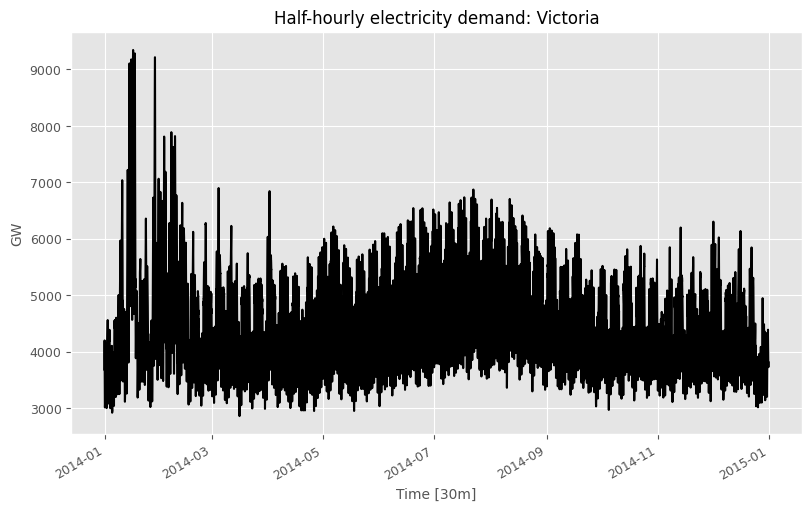

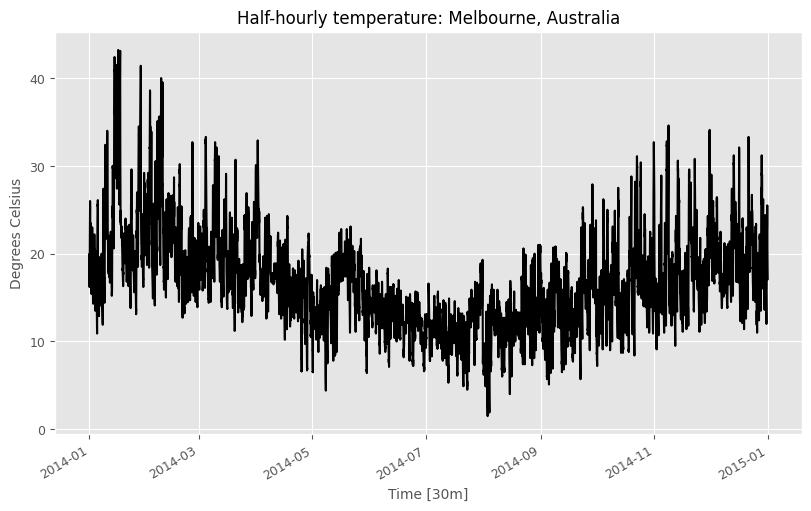

In [24]:
plot_series(vic_elec_df.query("unique_id == 'Demand'")[-2*24*365:],
            time_col="ds",
            target_col="y",
            xlabel="Time [30m]",
            ylabel="GW",
            title="Half-hourly electricity demand: Victoria")

plot_series(vic_elec_df.query("unique_id == 'Temperature'")[-2*24*365:],
            time_col="ds",
            target_col="y",
            xlabel="Time [30m]",
            ylabel="Degrees Celsius",
            title="Half-hourly temperature: Melbourne, Australia")

unique_id,Demand,Temperature
unique_id,,
Demand,1.000000,0.279781
Temperature,0.279781,1.000000


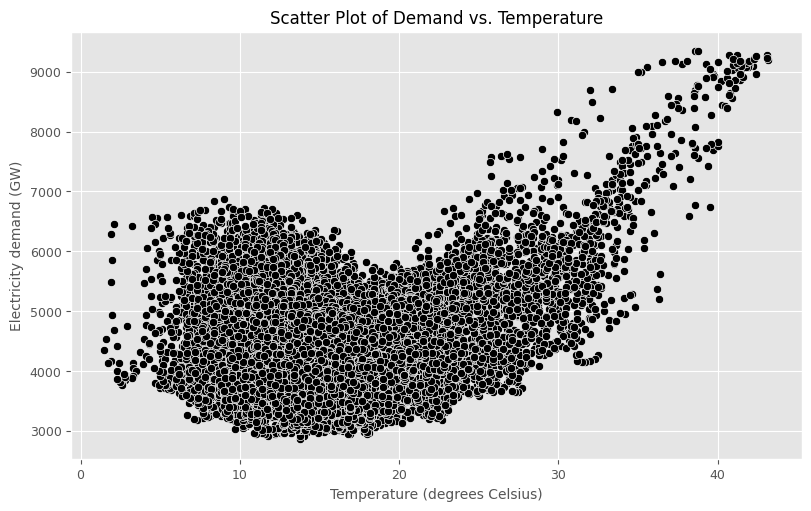

In [25]:
elec_2014 = vic_elec_df.query('ds >= "2014"')
elec_2014_pivot = elec_2014.pivot(
    index=["ds", "Holiday"], columns="unique_id", values="y"
).reset_index()
fig, ax = plt.subplots()
sns.scatterplot(data=elec_2014_pivot, x="Temperature", y="Demand", ax=ax)
ax.set_title("Scatter Plot of Demand vs. Temperature")
ax.set_xlabel("Temperature (degrees Celsius)")
ax.set_ylabel("Electricity demand (GW)")
fig.show()

elec_2014_pivot[['Demand', 'Temperature']].corr()

This scatterplot helps us to visualise the relationship between the variables.

Some notes on the scatterplot:

- It is clear that high demand occurs when temperatures are high due to the effect of air-conditioning.
- There is also a heating effect, where demand increases for very low temperatures.
- The use of (only) the correlation coefficient can sometimes be misleading since it only measures the strength of the linear relationship

### Correlation

It is common to compute correlation coefficients to measure the strength of the linear relationship between two variables.

The correlation between variables $x$ and $y$ is given by,

$$r = \frac{\sum (x_t - \bar{x})(y_t - \bar{y})}{\sqrt{\sum (x_t - \bar{x})^2}\sqrt{\sum (y_t - \bar{y})^2}}$$

The value of $r$ always lies between $-1$ and $1$ with negative values indicating a negative relationship and positive values indicating a positive relationship.



### Scatterplot matrices

When there are several potential predictor variables, it is useful to plot each variable against each other variable. Consider the eight time series shown below, showing quarterly visitor numbers across states and territories of Australia.

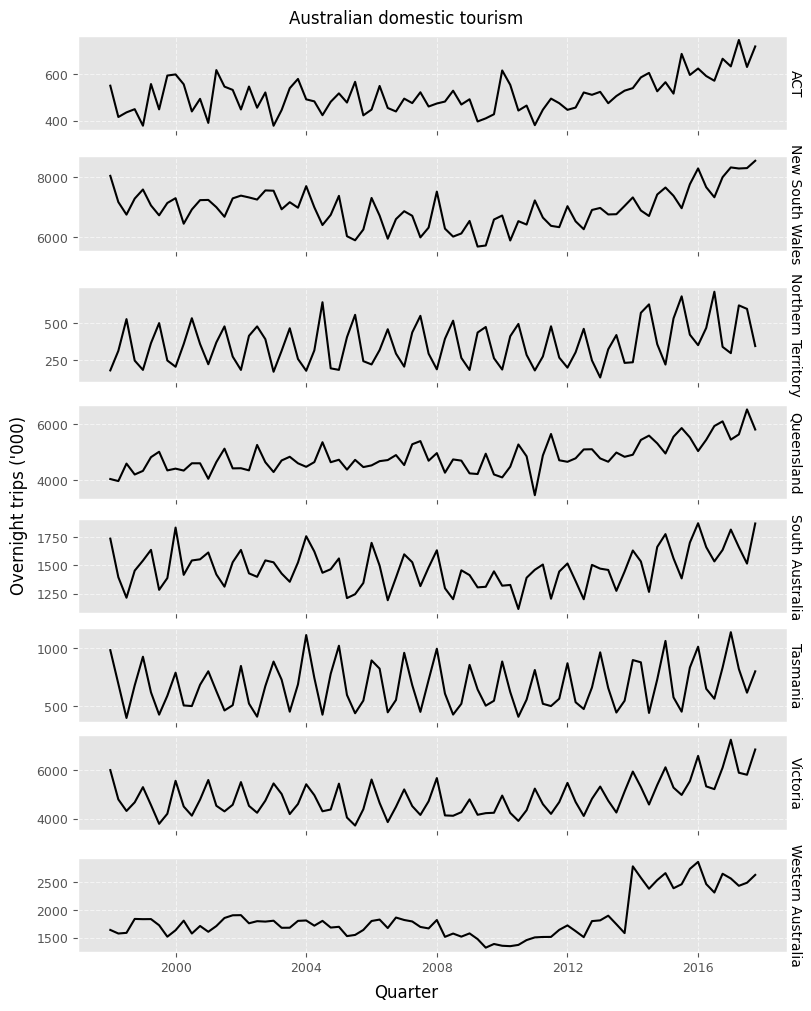

In [26]:
visitors = tourism.groupby(["State", "ds"], as_index=False)["y"].sum()
n_states = visitors["State"].nunique()
fig, axs = plt.subplots(n_states, 1, sharex=True, figsize=(8, 10))
for ax, (state, df_state) in zip(axs, visitors.groupby("State")):
    ax.plot(df_state["ds"], df_state["y"])
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.text(1.02, 0.5, state, va="center", ha="right",
        rotation=270, transform=ax.transAxes)
fig.suptitle("Australian domestic tourism")
fig.supylabel("Overnight trips ('000)", va="center", rotation=90)
fig.supxlabel("Quarter", ha="center")
fig.show()

To see the relationships between these eight time series, we can plot each time series against the others. These plots can be arranged in a scatterplot matrix.

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


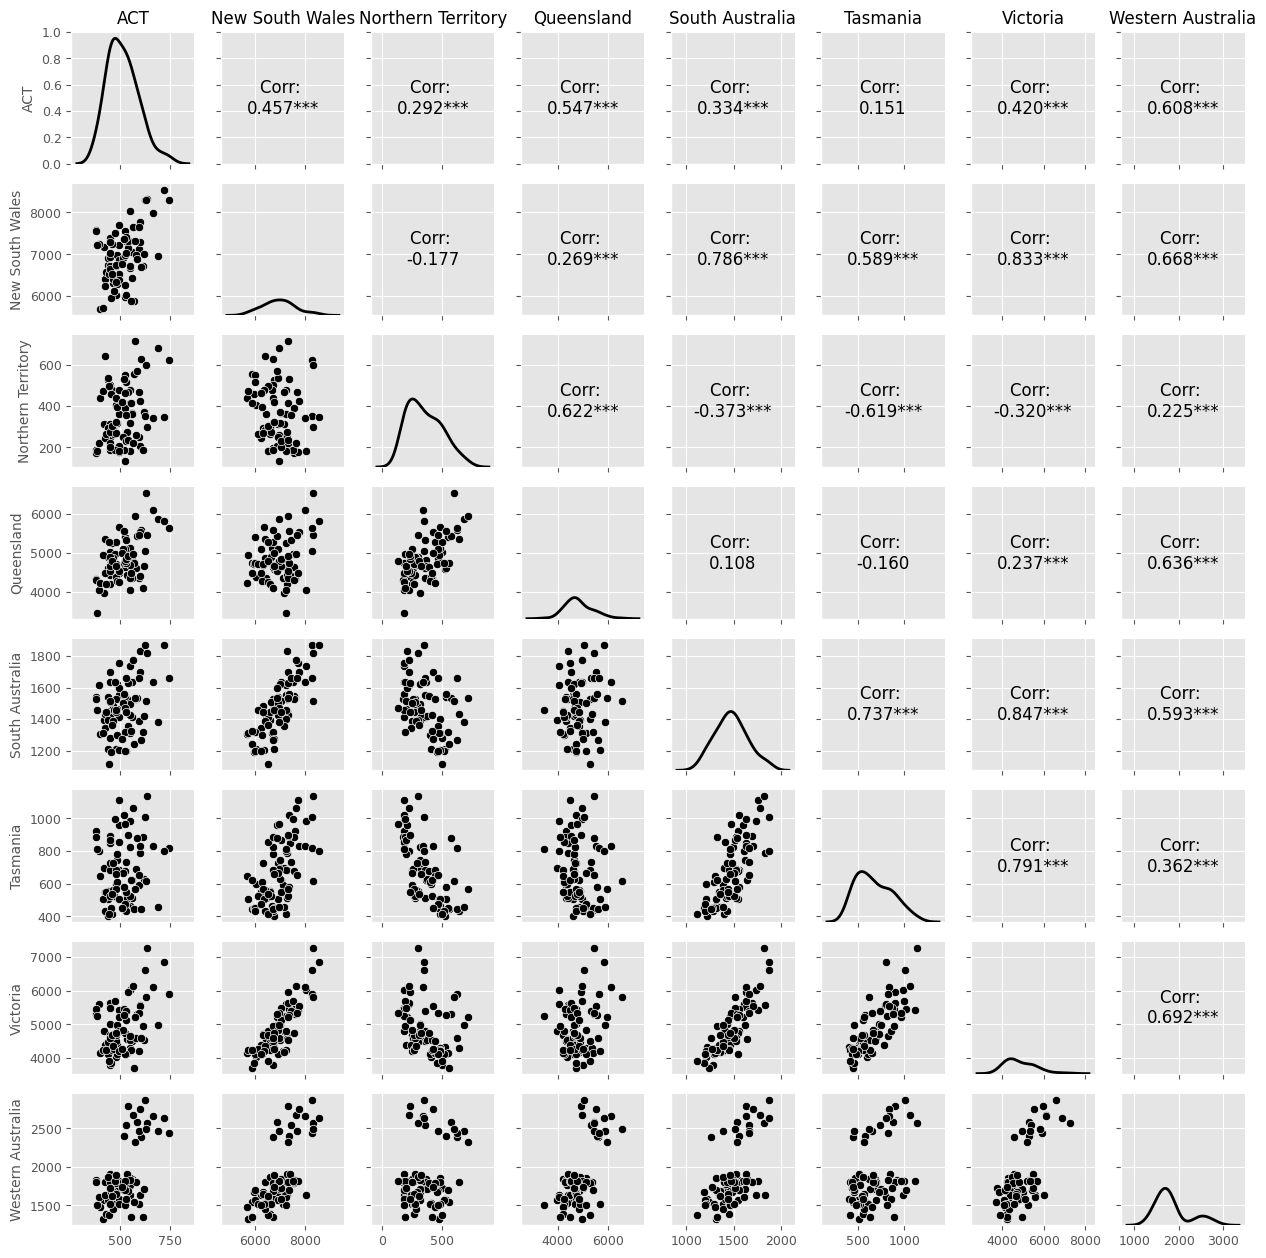

In [27]:
visitors_pivot = visitors.pivot(index="ds", columns="State", values="y").reset_index()
df_for_plot = visitors_pivot.drop(columns=["ds"])

def corrfunc(x, y, **kws):
    r, pvalue = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(
        f"Corr: \n{r:.3f}{'***' if pvalue < 0.05 else ''}",
        xy=(0.5, 0.5),
        xycoords="axes fraction",
        ha="center",
        va="center",
        fontsize=12,
    )


g = sns.PairGrid(df_for_plot, height=1.6)
g.map_lower(sns.scatterplot)
g.map_upper(corrfunc)
g.map_diag(sns.kdeplot, lw=2)

# Remove default axis labels
g.set(xlabel="")

# Move y-axis labels to the top
for i, col in enumerate(df_for_plot.columns):
    g.axes[0, i].set_title(col, fontsize=12)

fig.show()

For each panel, the variable on the vertical axis is given by the variable name in that row, and the variable on the horizontal axis is given by the variable name in that column. There are many options available to produce different plots within each panel. In the default version, the correlations are shown in the upper right half of the plot, while the scatterplots are shown in the lower half. On the diagonal are shown density plots.

The value of the scatterplot matrix is that it enables a quick view of the relationships between all pairs of variables.

Some notes:

- Mostly positive relationships are revealed, with the strongest relationships being between the neighbouring states located in the south and south east coast of Australia, namely, New South Wales, Victoria and South Australia.
- Some negative relationships are also revealed between the Northern Territory and other regions.
- The Northern Territory is located in the north of Australia famous for its outback desert landscapes visited mostly in winter. Peak visitation in the Northern Territory is in the July (winter) quarter in contrast to January (summer) quarter for the rest of the regions.

## Lag plots

The figure below displays scatterplots of quarterly Australian beer production, where the horizontal axis shows lagged values of the time series. Each graph shows $y_t$ plotted against $y_{t-k}$ for different values of $k$.

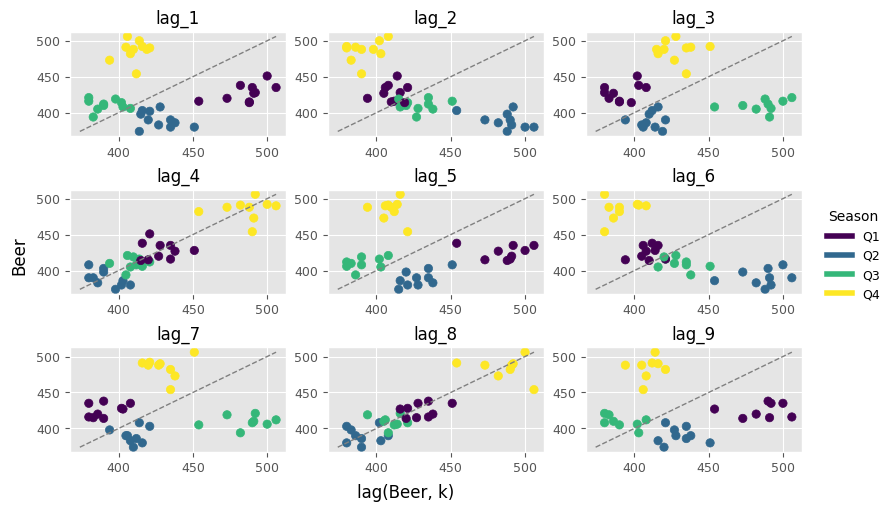

In [28]:
aus_production = pd.read_csv("data/aus_production.csv")
aus_production["ds"] = pd.to_datetime(aus_production["ds"])
recent_production = aus_production[["ds", "Beer"]].query("ds >= 2000")
recent_production.rename(columns={"Beer": "y"}, inplace=True)
recent_production["ds"] = pd.to_datetime(recent_production["ds"])
recent_production["Quarter"] = recent_production["ds"].dt.quarter

for lag in range(1, 10):
    recent_production[f"lag_{lag}"] = recent_production["y"].shift(lag)
lags = [f"lag_{i}" for i in range(1, 10)]
lims = [
    np.min([recent_production[lag].min() for lag in lags] +
        [recent_production["y"].min()]),
    np.max([recent_production[lag].max() for lag in lags] +
        [recent_production["y"].max()]),
]
fig, axes = plt.subplots(3, 3)
for ax, lag in zip(axes.flatten(), lags):
    ax.scatter(
        recent_production[lag],
        recent_production["y"],
        c=recent_production["Quarter"],
        cmap="viridis"
    )
    ax.plot(lims, lims, "grey", linestyle="--", linewidth=1)
    ax.set_title(lag)
unique_quarters = sorted(recent_production["Quarter"].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_quarters)))
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
labels = [f"Q{q}" for q in unique_quarters]
fig.legend(handles, labels, title="Season", loc="center left", bbox_to_anchor=(1.02, .5),
    frameon=False, borderaxespad=0,)
fig.supxlabel("lag(Beer, k)")
fig.supylabel("Beer")
fig.show()

Here the colours indicate the quarter of the variable on the vertical axis.

Some notes:
- The relationship is strongly positive at lags 4 and 8, reflecting the strong seasonality in the data.
- The negative relationship seen for lags 2 and 6 occurs because peaks (in Q4) are plotted against troughs (in Q2)

## Autocorrelation

Just as correlation measures the extent of a linear relationship between two variables, autocorrelation measures the linear relationship between *lagged values* of a time series.

There are several autocorrelation coefficients, corresponding to each panel in the lag plot. For example, $r_1$ measures the relationship between $y_t$ and $y_{t-1}$, $r_2$ measures the relationship between $y_t$ and $y_{t-2}$, and so on.

The value of $r_k$ can be written as

$$r_k = \frac{\sum_{t=k+1}^{T} (y_t - \bar{y})(y_{t-k} - \bar{y})}{\sum_{t=1}^{T} (y_t - \bar{y})^2}$$

where $T$ is the length of the time series. The autocorrelation coefficients make up the *autocorrelation function* or ACF.

The autocorrelation coefficients for the beer production data can be computed using the `acf()` function.

In [29]:
acf_df = pd.DataFrame(
    {"Lag": range(10), "ACF": sm.tsa.acf(recent_production["y"], nlags=9, fft=False, bartlett_confint=False)}
    ).set_index("Lag")
acf_df[1:]

,ACF
Lag,
1,-0.052981
2,-0.758175
3,-0.026234
4,0.802205
5,-0.077471
6,-0.657451
7,0.001195
8,0.707254
9,-0.088756


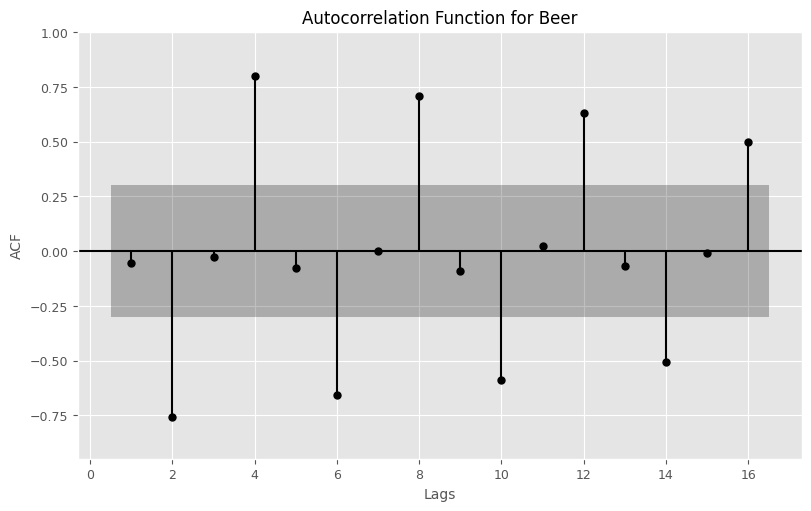

In [30]:
recent_production["ds"] = pd.to_datetime(recent_production["ds"])
fig, ax = plt.subplots()
plot_acf(recent_production["y"], lags=16,
         ax=ax,
         zero=False, bartlett_confint=False, auto_ylims=True)

ax.set_title("Autocorrelation Function for Beer")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")

fig.show()

Some notes:
- $r_4$ is higher than for the other lags. This is due to the seasonal pattern in the data: the peaks tend to be four quarters apart and the troughs tend to be four quarters apart.
- $r_2$ is more negative than for the other lags because troughs tend to be two quarters behind peaks.
- The band indicates whether the correlations are significantly different from zero.


### Trend and seasonality in ACF plots

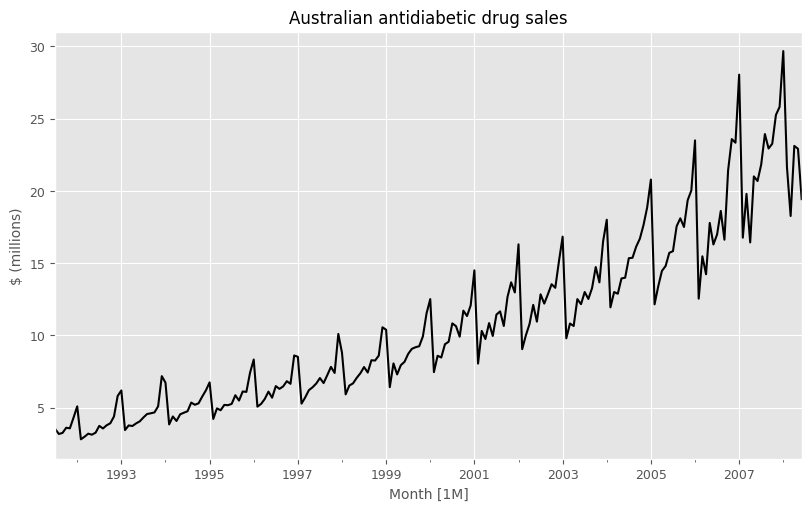

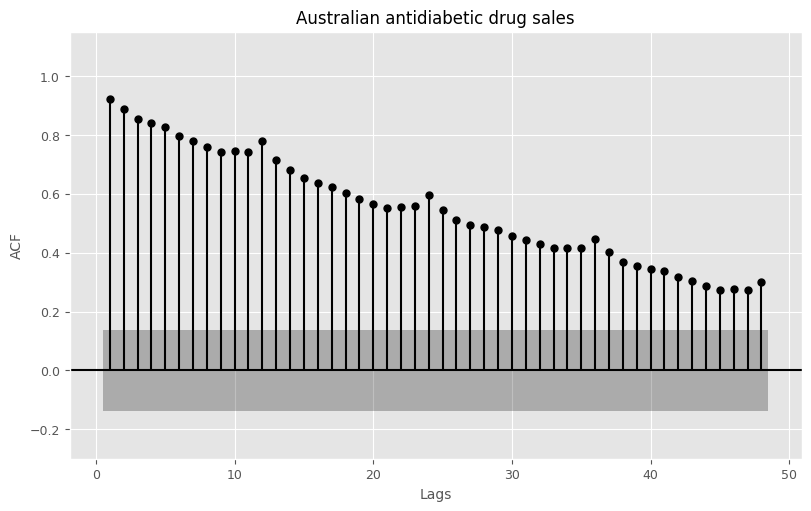

In [31]:
total_cost_df["Month"] = pd.to_datetime(total_cost_df["Month"])

plot_series(total_cost_df,
            time_col="Month",
            target_col="Cost",
            xlabel="Month [1M]",
            ylabel="$ (millions)",
            title="Australian antidiabetic drug sales")

fig, ax = plt.subplots()
plot_acf(total_cost_df["Cost"], lags=48, ax=ax,
         zero=False, bartlett_confint=False, auto_ylims=True)

ax.set_title("Australian antidiabetic drug sales")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")
ax.set_ylim(bottom=-0.3)

fig.show()

Some notes on the ACF Plot:

- Slow decrease in the ACF as the lags increase is due to the trend
- The "scalloped" shape is due the seasonality

## White noise

Time series that show no autocorrelation are called white noise.

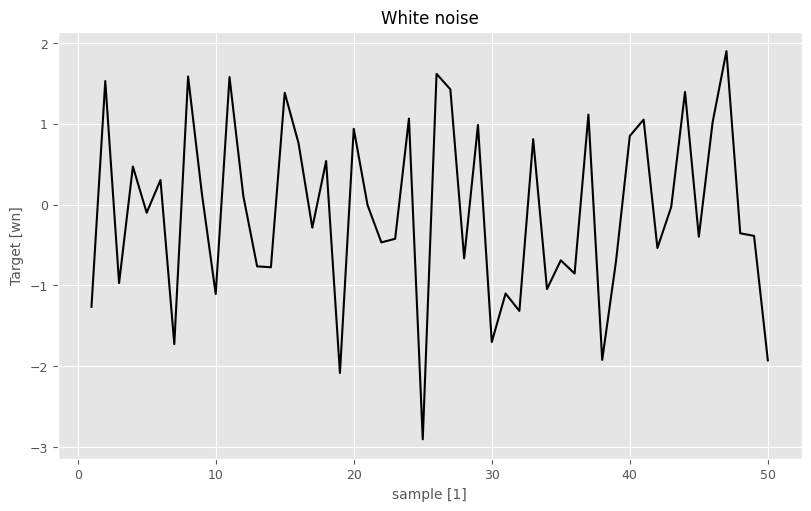

In [32]:
np.random.seed(30)
y = pd.DataFrame({"wn": np.random.normal(0, 1, 50), "ds": np.arange(1, 51)})
plot_series(y,
            time_col="ds",
            target_col="wn",
            xlabel="sample [1]",
            ylabel="Target [wn]",
            title = "White noise")

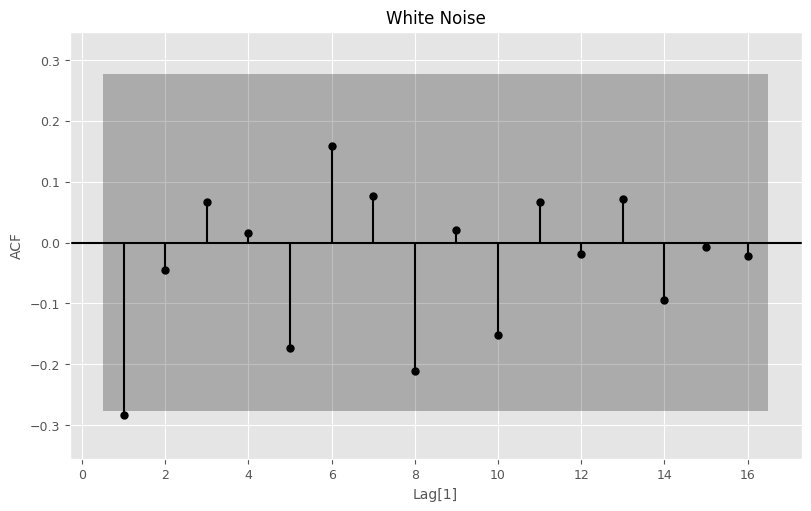

In [33]:
fig, ax = plt.subplots()
plot_acf(y["wn"], lags=16, ax=ax,
         zero=False, bartlett_confint=False,
         auto_ylims=True)
ax.set_title("White Noise")
ax.set_xlabel("Lag[1]")
ax.set_ylabel("ACF")
fig.show()

Some notes:
- For white noise series, we expect each autocorrelation to be close to zero. Of course, they will not be exactly equal to zero as there is some random variation.
- For a white noise series, we expect $95\%$ of the spikes in the ACF to lie within $\pm 1.96/\sqrt{T}$ where $T$ is the length of the time series.
- It is common to plot these bounds on a graph of the ACF (bands above)
- If one or more large spikes are outside these bounds, or if substantially more than 5% of spikes are outside these bounds, then the series is probably not white noise.
- In this example, $T=50$ and so the bounds are at $\pm 1.96/\sqrt{50} = 0.28$. Almost all of the autocorrelation coefficients lie within these limits, confirming that the data are white noise.